<a href="https://colab.research.google.com/github/PashaIanko/RestrictedBolzmannMachine/blob/EMNIST/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Helper links:
- https://github.com/pytorch/vision/blob/main/torchvision/datasets/omniglot.py

## **Packages, Constants & Functions**

In [181]:
%%capture

url_dbn = 'https://raw.githubusercontent.com/PashaIanko/RestrictedBolzmannMachine/main/DBN.py'
url_rbm = 'https://raw.githubusercontent.com/PashaIanko/RestrictedBolzmannMachine/main/RBM.py'

utils = {
    'DBN.py': url_dbn,
    'RBM.py': url_rbm,
}

for file, url in utils.items():
    !wget -O {file} {url} {file}

In [182]:
import torch
import torchvision as tv
from torchvision import datasets
import torch.nn.functional as functional 

# Models
from DBN import DBN

# Plotting
import matplotlib.pyplot as plt

# Download
from os import path

# Utils
from abc import ABC, abstractmethod, abstractproperty
from scipy import cluster
import numpy as np
import random
import math
import tqdm

# Plotting
import seaborn as sns

In [183]:
class PreprocParams:
    crop_size = 28
    mean = 0.1307
    std = 0.3081
    visualization_threshold = 0.1
    image_size = crop_size
    noise_level = 0.2
    strategy = 'MNIST'

class TrainParameters:
    epochs = 50
    batch_size = 100
    train_size = 60000
    test_size = 10000
    class_num = 10

class FFNNTrainParameters:
    epochs = 120

class PerceptronTrainParameters:
    epochs = 1500
    
class DBMParameters(ABC):
    def __init__(self, image_height, image_width):
        super().__init__()
        self.K = 1
        self.learning_rate = 0.1
        self.lr_decay = False
        self.init_momentum = 0.5
        self.fin_momentum = 0.9
        self.w_decay = 0.0002
        self.xavier_init = False
        self.increase_to_cd_k = False
        self.use_gpu = True
        
        self.image_height = image_height
        self.image_width = image_width


    @abstractproperty
    def hidden_units(self):
        pass

    @property
    def n_hidden_layers(self):
        return len(self.hidden_units)

In [184]:
class DBMDeepParameters(DBMParameters):
    def __init__(self, image_height, image_width):
        super().__init__(image_height, image_width)
    
    @property
    def hidden_units(self):
        return [500, 500] #, 1000]
        

class DBMShallowParameters(DBMParameters):
    def __init__(self, image_height, image_width):
        super().__init__(image_height, image_width)
    
    @property
    def hidden_units(self):
        return [500]  # shallow model for adversarial attacks

In [185]:
class FeedForward(torch.nn.Module):
  def __init__(self,
               first_hidden_layer_size,
               class_num,
               input_size):
    super().__init__()
    self.first_hidden = torch.nn.Linear(input_size, first_hidden_layer_size)
    self.output = torch.nn.Linear(first_hidden_layer_size, class_num)

  def forward(self, input):
    input = input.view((input.shape[0], -1))
    relu = torch.nn.ReLU()
    first_hidden_repr = relu(self.first_hidden(input))
    output = self.output(first_hidden_repr)
    return output

In [186]:
def fix_seeds():
    torch.manual_seed(0)
    random.seed(0)
    np.random.seed(0)

In [187]:
def visualize_symbols(dataset, n_subplots, image_shape):
    n_rows_cols = int(math.sqrt(n_subplots))
    _, axes = plt.subplots(
        n_rows_cols, 
        n_rows_cols, 
        sharex = True,
        sharey = True,
        figsize = (10, 10)
    )
    for i in range(n_subplots):
        row = i % n_rows_cols
        col = i // n_rows_cols
        img = dataset[i] 
        axes[row, col].imshow(torch.flatten(img).reshape(image_shape), cmap='binary')

In [188]:
def find_image(ds, label):
    for item in ds:
        if item[1] == label:
            return item[0]

def visualize_labels(labels, data, targets, figsize = (10, 10)):
    n_subplots = len(labels)
    
    n_rows_cols = int(math.sqrt(n_subplots))
    _, axes = plt.subplots(
        n_rows_cols, 
        n_rows_cols, 
        sharex = True,
        sharey = True,
        figsize = figsize
    )

    for i in range(n_subplots):
        col = i % n_rows_cols
        row = i // n_rows_cols
        label = labels[i]
        
        img_index = np.where(targets == label)[0][0]
        image = data[img_index]
        axes[row, col].imshow(image, cmap = 'binary')

def prepare_data(ds, label_from, label_to):
    labels = []
    images = []
    for item in ds:
        if label_from <= item[1] <= label_to:
            labels.append(item[1])
            images.append(item[0])
    return images, labels

In [189]:
def get_layer_representations(n_layers, model, input_data):
    internal_reps = []
    for layer_n in range(n_layers):
        if layer_n == 0:
            repr = get_layer_representation(
                input = input_data,
                model = model,
                layer_number = layer_n
            )
            internal_reps.append(repr)
        else:
            # Previous hidden is now an input data for next hidden
            input = internal_reps[layer_n - 1]
            repr = get_layer_representation(
                input = input,
                model = model,
                layer_number = layer_n
            )
            internal_reps.append(repr)
    return internal_reps

In [190]:
def move_parameters_to_cpu(dbn_mnist):
    for layer in dbn_mnist.rbm_layers:
        layer.W = layer.W.cpu()
        layer.h_bias = layer.h_bias.cpu()
        layer.v_bias = layer.v_bias.cpu()

def apply_threshold(weights, threshold=0):
    return weights * (abs(weights) > threshold)
  
def plot_layer_receptive_fields(weights_matrices, num_subplots, 
                                img_width, img_height, 
                                fig_size = (20, 20),
                                suptitle = ''):
    n_rows_cols = int(math.sqrt(num_subplots))
    fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=fig_size)
    for i in range(num_subplots):
        row = i % n_rows_cols
        col = i // n_rows_cols
        
        # Matrix of connection strength (W) of i-th unit of the layer.
        # Reshape from 'linear' to 'image' representation
        W_matrix = weights_matrices[i, :].reshape((img_height, img_width))
        axes[row, col].imshow(W_matrix, cmap = plt.cm.gray)
    fig.suptitle(suptitle)

In [191]:
def project_hidden_layer(weights_matrices, layer_numb):
    
    # layer_numb starts from 2 (number of hidden layer)
    if layer_numb > len(weights_matrices):
        print(f'Mistake in project_hidden_layer, accessing wrong layer')
        return 
    layers = weights_matrices[:layer_numb]
    cur_layer = layers[0]
    for i in range(1, len(layers)):
        cur_layer = layers[i] @ cur_layer
    return cur_layer

In [192]:
def get_layer_representation(input, model, layer_number):
    flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor)
    hidden_repr, _ = model.rbm_layers[layer_number].to_hidden(flattened_input)
    return hidden_repr

In [193]:
def get_mask(labels, label):
    return labels.numpy() == label

def label_to_mean_hidden_repr(hidden_representation, images, labels):
    hidden_representation_np = hidden_representation.numpy()
    return {
        label: hidden_representation_np[get_mask(labels, label)].mean(axis=0)
        for label in np.unique(labels.numpy())
    }

def get_hidden_representation_matrix(label_to_mean_hidden_repr, labels):
    return np.concatenate(
        [np.expand_dims(
            label_to_mean_hidden_repr[label], axis = 0
        )
        for label in np.unique(labels.numpy())]
    )

In [194]:
def plot_dendrogram(mean_repr_matrix, title = ''):
    fig, ax = plt.subplots()
    linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")  # we run the clustering algorithm here
    dendrogram = cluster.hierarchy.dendrogram(linkage)
    ax.set_title(title)
    return dendrogram

In [195]:
def train(network, input, targets, epochs=1000):
  print_every_n_epochs = 100 if epochs >= 1000 else 10
  optimizer = torch.optim.SGD(network.parameters(), lr=0.05)
  loss_fn = torch.nn.CrossEntropyLoss()

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = network(input)  # .squeeze()
    loss = loss_fn(predictions, targets)
    loss.backward()
    optimizer.step()
    if epoch % print_every_n_epochs == 0:
      print("epoch {}/{}, loss = {:.6f}".format(epoch, epochs, loss))
    
def attach_perceptron(model, layer_num, class_num):
    rbm_layer_size = model.rbm_layers[layer_num].W.shape[1]
    return Perceptron(rbm_layer_size, class_num)

def compute_accuracy(predictions, targets):
    predictions_indices = predictions.max(axis=1).indices  # convert probabilities to indices
    accuracy = (predictions_indices == targets).sum() / len(targets)
    return accuracy.item()

class Perceptron(torch.nn.Module):
  def __init__(self, rbm_layer_size, class_num):
    super().__init__()
    self.linear = torch.nn.Linear(rbm_layer_size, class_num)  # because 10 classes. You declare input and output

  def forward(self, x):  # called when applied on some data, basic method
    return self.linear(x)

In [196]:
def inject_noise(mnist_data, noise_level):
  random_gaussian_tensor = torch.randn(mnist_data.shape)/6.6 + .6
  probability_tensor = torch.ones(mnist_data.shape)*noise_level
  mask_tensor = torch.bernoulli(probability_tensor)
  return mnist_data - mask_tensor * mnist_data + mask_tensor * random_gaussian_tensor

In [197]:
def accuracy_at_noise_level(
    noisy_input,
    targets,

    rbm_model,
    hidden_layer_number,

    perceptron_model,
    ffnn_model
):
  
  hidden_repr_noisy = get_layer_representation(noisy_input, rbm_model, hidden_layer_number)

  predictions_hidden = perceptron_model(hidden_repr_noisy)
  predictions_ffnn = ffnn_model(noisy_input.reshape(
      (noisy_input.shape[0], noisy_input.shape[1] * noisy_input.shape[2]))
  )
  
  acc_hidden = compute_accuracy(predictions_hidden, targets)
  acc_ffnn = compute_accuracy(predictions_ffnn, targets)
  return acc_hidden, acc_ffnn

In [198]:
def plot_noise_robustness_curves(
  noise_levels,
  dbn_model,
  ffnn_model,
  perceptron_model,  # perceptron_first_hidden

  data,  # data_test,
  targets  # targets_test
):
  accuracy_values_first_hidden = []
  accuracy_values_ffnn = []

  for noise_level in noise_levels:
    accuracy_first_hidden, accuracy_ffnn = accuracy_at_noise_level(
        noisy_input = inject_noise(
          data, 
          noise_level
        ),
        targets = targets,

        rbm_model = dbn_model,
        hidden_layer_number = 0,

        perceptron_model = perceptron_model,
        ffnn_model = ffnn_model
    )
    accuracy_values_first_hidden.append(accuracy_first_hidden)
    accuracy_values_ffnn.append(accuracy_ffnn)

  fig, ax = plt.subplots()
  ax.plot(range(len(noise_levels)), accuracy_values_first_hidden,
            marker = 'o',
            markerfacecolor = 'white', 
            markersize = 9
  )
  ax.plot(range(len(noise_levels)), accuracy_values_ffnn,
          marker = 'o',
          markerfacecolor = 'white', 
          markersize = 9
  )

  ax.set_title("Robustness to noise")
  ax.set_xlabel("Noise level (%)")
  ax.set_ylabel("Accuracy")
  plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
  plt.grid()
  plt.legend(["First hidden", "FFNN"])


In [199]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image

In [200]:
class DBNWithReadOut(torch.nn.Module):
    def __init__(self, dbn_model, perceptron):
        super().__init__()
        self.readout = perceptron
        self.dbn_model = dbn_model

    def forward(self, image):
        x, _ = self.dbn_model.forward(image)
        x = self.readout.forward(x)
        return x

In [201]:
def attack_demo(image, label, attacked_model):
    f = plt.figure()
    s1 = f.add_subplot(1, 2, 1)
    s2 = f.add_subplot(1, 2, 2)
    
    s1.imshow(
        image.reshape(PreprocParams.crop_size, PreprocParams.crop_size)
    )

    image.requires_grad = True
    model_output = attacked_model(image)
    pred = torch.argmax(model_output)

    s1.set_title(
        f"""
        Image before
        True label: {label}
        Predicted label: {pred}
        """
    )

    loss = torch.nn.functional.cross_entropy(
        target = torch.tensor([label]),
        input = model_output
    )
    
    attacked_model.zero_grad()
    loss.backward()

    image_grad = image.grad.data
    perturbed_image = fgsm_attack(image, 0.2, image_grad)
    perturbed_image_np = perturbed_image.detach().numpy()

    pred_adversarial = torch.argmax(
        attacked_model(perturbed_image)
    )
    
    s2.imshow(
        perturbed_image_np.reshape(PreprocParams.crop_size, PreprocParams.crop_size)
    )
    s2.set_title(
        f"""
        Image after adv. attack
        True label: {label}
        Predicted label: {pred_adversarial}
        """
    )

In [202]:
def test_robustness_to_attack(model, device, test_loader, epsilon, num_steps=0, verbose=True):
    correct = 0
    print_reconstruction = num_steps > 0

    for data, target in tqdm.tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        data = data.reshape(1, 28, 28)
        data.requires_grad = True  # Important for Attack

        output = model.forward(data)

        init_pred = torch.argmax(output)
        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        if (print_reconstruction and verbose):
          print("\nHere's the original sample:\n")
          plt.imshow(data.detach().numpy().reshape(28,28))
          plt.show()

        loss = functional.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data  # collect the gradient of the input data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        if (print_reconstruction and verbose):
            print("\nHere's a perturbed sample:\n")
            plt.imshow(perturbed_data.detach().numpy().reshape(28,28))
            plt.show()


        # If requested, reconstruct the input iterating forward-backward dynamics
        if num_steps > 0:
            for __ in range(0, num_steps):
                perturbed_data, __ = model.dbn_model.reconstruct(perturbed_data)
            if (print_reconstruction and verbose):
                print(f"\nHere's what a {num_steps}-steps reconstructed sample looks like:\n")
                plt.imshow(perturbed_data.detach().numpy().reshape(28,28))
                plt.show()
                print_reconstruction = False

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        # get the index of the max element in the output
        final_pred = output.max(1, keepdim=True)[1]
        if final_pred.item() == target.item():
            correct += 1

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    if verbose:
      print("\nEpsilon: {}\tTest Accuracy = {} / {} = {}\n".format(epsilon,
            correct, len(test_loader), final_acc))

    return final_acc

In [203]:
def test_epsilon_values_effect(model, n_steps, epsilons):
  accuracies = list()

  for eps in epsilons:
      acc = test_robustness_to_attack(
          model, 
          device, 
          test_loader, 
          eps, 
          num_steps = n_steps, 
          verbose=False
      )
      accuracies.append(acc)
  return accuracies

## **Data preparation**

### Download


- For neural networks, we need to scale data before learning
- Need to obtain tensor shape
- Fix seeds for reproducibility

In [204]:
%%capture 
def get_emnist_data():
    fix_seeds()

    transformer = tv.transforms.Compose(
        [
            #tv.transforms.CenterCrop(CROP_SIZE_),
            tv.transforms.ToTensor(),
            
            # Transform to {-1, 1} binary image
            tv.transforms.Normalize(
                mean=(PreprocParams.mean,), 
                std=(PreprocParams.std)
            ),

            # Rotate
            # tv.transforms.RandomRotation(degrees = 90) 
        ]
    )

    data = tv.datasets.EMNIST(
        root = 'data/',
        train = True,
        download = True,
        transform = transformer,
        split = 'digits',
        # shuffle = False
    )

    data.data = (data.data.type(torch.FloatTensor) / 255)
    return data.data, data.targets

def get_mnist_data():
    train = tv.datasets.MNIST(
        'data/', 
        train = True, 
        download = True,
        transform=tv.transforms.Compose(
            [tv.transforms.ToTensor()]
        )
    )

    test = tv.datasets.MNIST(
        'data/', 
        train = False, 
        download = True,
        transform=tv.transforms.Compose(
            [tv.transforms.ToTensor()]
        )
    )

    targets = torch.cat((train.targets, test.targets))
    data = torch.cat((train.data, test.data))
    data = (data.type(torch.FloatTensor) / 255)
    return data, targets

def get_data(strategy):
    if strategy == 'EMNIST':
        return get_emnist_data()
    elif strategy == 'MNIST':
        return get_mnist_data()

In [205]:
%%capture
data, targets = get_data(PreprocParams.strategy)
print(f'Data size: {data.shape} {targets.shape}')

### Train / Test split

In [206]:
data_train = data[: TrainParameters.train_size, :]
targets_train = targets[: TrainParameters.train_size]

data_test = data[
  TrainParameters.train_size : TrainParameters.train_size + TrainParameters.test_size, :
]
targets_test = targets[
  TrainParameters.train_size : TrainParameters.train_size + TrainParameters.test_size
]

print(f"""
        Train size: {data_train.shape, targets_train.shape}
        Test size: {data_test.shape, targets_test.shape}
""")


        Train size: (torch.Size([60000, 28, 28]), torch.Size([60000]))
        Test size: (torch.Size([10000, 28, 28]), torch.Size([10000]))



### Exploration & visualization

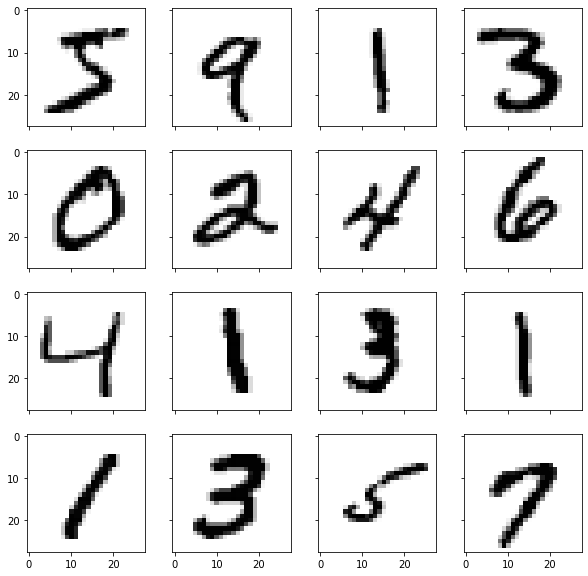

In [207]:
visualize_symbols(
    data_train, 
    n_subplots = 16, 
    image_shape = (PreprocParams.crop_size, PreprocParams.crop_size)
)

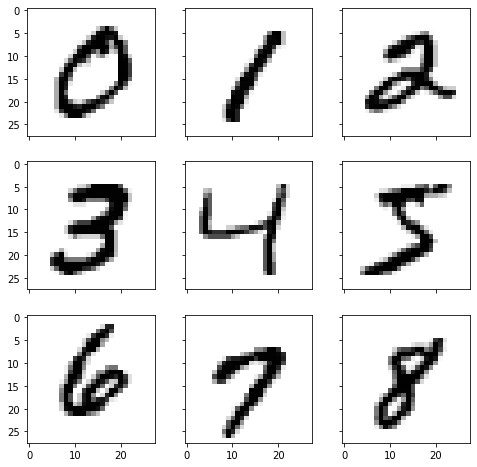

In [208]:
# Visualize first few symbols
visualize_labels(
    labels = [
        0, 1, 2,
        3, 4, 5,
        6, 7, 8
    ],
    data = data_train,
    targets = targets_train,
    figsize = (8, 8)
)

### Class distribution

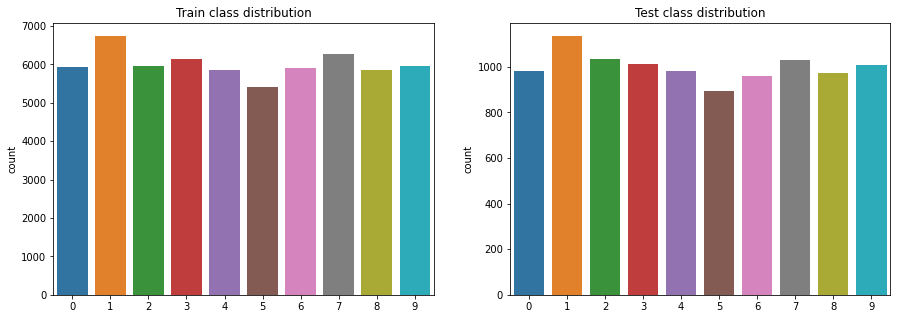

In [209]:
fig, axes = plt.subplots(1, 2, figsize = (15, 5))
sns.countplot(
    x = targets_train.numpy(), ax = axes[0]

)
_ = axes[0].set_title('Train class distribution')

sns.countplot(
    x = targets_test.numpy(), 
    ax = axes[1]
)
_ = axes[1].set_title('Test class distribution')

- 1st conclusion:  
    - 1 Dataset
    - 10 distinct symbols (for 'digits' split)
    - Approximately uniform class distribution
    - ~ 10% images per class
    - Digits are centered in the image and do not occupy the whole square (-> apply center crop)

## **Deep Belief Network model & fit**

- Deep Belief Network - a stack of Restricted Bolzmann Machines
    - RBM is a bipartite graph with input and hidden layer
    - Hidden layer captures dependencies and features
- Each layer learns more complex and abstract features
- Used as feature extraction method (generative model)
- No output neurons
- Two phases (negative & positive) during learning (reconstruction)




### Prepare model

Here, we prepare a deep (for internal representations) and a shallow (for adversarial attacks) models

In [210]:
fix_seeds()

dbm_deep_params = DBMDeepParameters(
    image_height = PreprocParams.crop_size,
    image_width = PreprocParams.crop_size
)

model_deep = DBN(
    visible_units = dbm_deep_params.image_width * dbm_deep_params.image_height,
    hidden_units = dbm_deep_params.hidden_units,
    k = dbm_deep_params.K,
    learning_rate = dbm_deep_params.learning_rate,
    learning_rate_decay = dbm_deep_params.lr_decay,
    initial_momentum = dbm_deep_params.init_momentum,
    weight_decay = dbm_deep_params.w_decay,
    xavier_init = dbm_deep_params.xavier_init,
    increase_to_cd_k = dbm_deep_params.increase_to_cd_k,
    use_gpu = dbm_deep_params.use_gpu
)


In [211]:
fix_seeds()

dbm_shallow_params = DBMShallowParameters(
    image_height = PreprocParams.crop_size,
    image_width = PreprocParams.crop_size
)

model_shallow = DBN(
    visible_units = dbm_shallow_params.image_width * dbm_shallow_params.image_height,
    hidden_units = dbm_shallow_params.hidden_units,
    k = dbm_shallow_params.K,
    learning_rate = dbm_shallow_params.learning_rate,
    learning_rate_decay = dbm_shallow_params.lr_decay,
    initial_momentum = dbm_shallow_params.init_momentum,
    weight_decay = dbm_shallow_params.w_decay,
    xavier_init = dbm_shallow_params.xavier_init,
    increase_to_cd_k = dbm_shallow_params.increase_to_cd_k,
    use_gpu = dbm_shallow_params.use_gpu
)

### Fit

In [212]:
# %%capture

fix_seeds()

model_deep.train_static(
    data_train,
    targets_train,
    TrainParameters.epochs,
    TrainParameters.batch_size
)

move_parameters_to_cpu(model_deep)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.9942   |0.0528   |345.0992 |13.4257   |
|20    |0.9481   |0.0496   |327.0140 |12.7256   |
|30    |0.9336   |0.0501   |318.3804 |12.3402   |
|40    |0.9280   |0.0491   |315.6078 |12.4171   |
|50    |0.9258   |0.0499   |314.7289 |12.4236   |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.2501   |0.0420   |275.4546 |11.3677   |
|20    |1.2093   |0.0429   |270.3755 |11.7795   |
|30    |1.1996   |0.0415   |269.3027 |12.7107   |
|40    |1.1915   |0.0428   |266.4349 |11.6343   |
|50    |1.1904   |0.0410   |266.7249 |12.1442   |


In [213]:
# %%capture

fix_seeds()

model_shallow.train_static(
    data_train,
    targets_train,
    TrainParameters.epochs,
    TrainParameters.batch_size
)

move_parameters_to_cpu(model_shallow)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.9942   |0.0528   |345.0992 |13.4257   |
|20    |0.9481   |0.0496   |327.0140 |12.7256   |
|30    |0.9336   |0.0501   |318.3804 |12.3402   |
|40    |0.9280   |0.0491   |315.6078 |12.4171   |
|50    |0.9258   |0.0499   |314.7289 |12.4236   |


## **Linear read-outs. Receptive fields visualization**

Lets understand the structure of network & layers
- Input layer size - (IMG_SIZE_ * IMG_SIZE_)
- 0-level of RBM network with N units -> has connection matrix W. 
Size of W = N_units * (IMG_SIZE_ * IMG_SIZE_)
- We can consider W matrix of 0-level as N "images" of size (IMG_SIZE_ * IMG_SIZE_)
- Hence, we can visualize connection strengths, starting from 0 hidden level

Another considerations:
- For example, in the architecture with units = [500, 500, 2000], the second hidden layer consists of 500 units, each associated with 500 units of the 1st hidden layer (500 x 500 matrix)
- We need to visualize (IMG_SIZE_ * IMG_SIZE_) images of 2nd hidden layer receptive fields
- The dimension of 1st hidden layer is n_units * (IMG_SIZE * IMG_SIZE).
- **Therefore**, we need to perform matrix multiplication, to turn (500 x 500) layer to (500 x (IMG_SIZE x IMG_SIZE)) layer

In [214]:
for i in range(len(model_deep.rbm_layers)):
    print(
        f"""Dimension of connection matrix at {i} level: {model_deep.rbm_layers[i].W.size()}
        """
    )
print(f'Total: {model_deep.n_layers} hidden layers')

Dimension of connection matrix at 0 level: torch.Size([784, 500])
        
Dimension of connection matrix at 1 level: torch.Size([500, 500])
        
Total: 2 hidden layers


### Preprocessing (filtering) learned weights matrices

In [215]:
# Converting and processing W matrices of hidden layers

learned_weights = [
    # We transpose for convenience (matrices[i, :] is more intuitive than matrices[:, i])
    model_deep.rbm_layers[i].W.transpose(0, 1).numpy() for i in range(model_deep.n_layers)
]

learned_weights_thresh = [
    apply_threshold(weights_matrix, PreprocParams.visualization_threshold) 
    for weights_matrix in learned_weights
]

### Hidden layer receptive fields

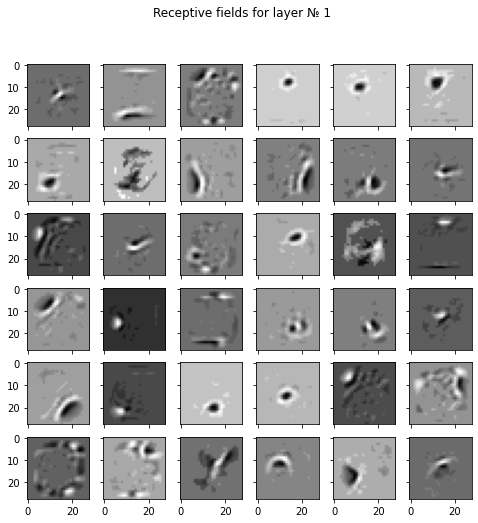

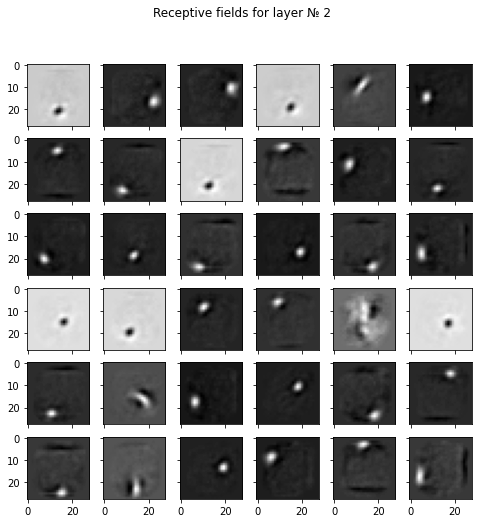

In [216]:
for layer in range(dbm_deep_params.n_hidden_layers):
    title = f'Receptive fields for layer № {layer + 1}'
    
    if layer == 0:
        # No projection
        weights = learned_weights_thresh[layer]
    else:
        weights = project_hidden_layer(
            learned_weights_thresh,
            layer_numb = layer + 1  # Yes, problems with indexes
        )
    
    plot_layer_receptive_fields(
        weights,
        num_subplots = 36,
        img_width = PreprocParams.crop_size,
        img_height = PreprocParams.crop_size,
        suptitle = title,
        fig_size = (8, 8)
    )
    

## **Clustering internal representations**

### Representation matrices

In [217]:
hidden_representations = get_layer_representations(
    n_layers = dbm_deep_params.n_hidden_layers,
    model = model_deep,
    input_data = data_train
)
print(f'Total: {len(hidden_representations)} hidden representations')

Total: 2 hidden representations


In [218]:
# Label to mean representation
labels_to_mean = [
    label_to_mean_hidden_repr(
        hidden_representation,
        data_train,
        targets_train
    )
    for hidden_representation in hidden_representations
]

In [219]:
representation_matrices = [
    get_hidden_representation_matrix(
        label_to_mean,
        targets_train
    )
    for label_to_mean in labels_to_mean
]

### Plotting dendrograms

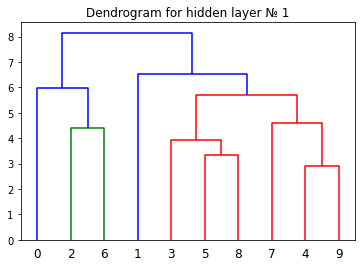

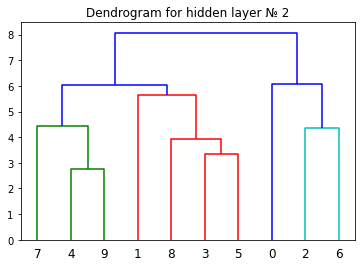

In [220]:
for index, mean_repr_matrix in enumerate(representation_matrices):
    plot_dendrogram(
        mean_repr_matrix,
        title = f'Dendrogram for hidden layer № {index + 1}'
    )

## Train all layers read-outs

Here, we attach perceptrons to all levels of deep belief network, in order to compare accuracy and train time metrics

In [221]:
perceptrons = []

for layer_n in range(dbm_deep_params.n_hidden_layers):
    # Perceptron, attached to 'layer_n' hidden layer
    perceptron = attach_perceptron(
        model = model_deep,
        layer_num = layer_n,
        class_num = TrainParameters.class_num  # For 'digits' split EMNIST -> 10 classes
    )

    # As input - hidden representation
    train(
        perceptron, 
        hidden_representations[layer_n],
        targets = targets_train,
        epochs = PerceptronTrainParameters.epochs
    )
    print('\n')

    perceptrons.append(
        perceptron
    )

test_representations = get_layer_representations(
    n_layers = dbm_deep_params.n_hidden_layers,
    model = model_deep,
    input_data = data_test
)

epoch 0/1500, loss = 2.288140
epoch 100/1500, loss = 0.668210
epoch 200/1500, loss = 0.498925
epoch 300/1500, loss = 0.430961
epoch 400/1500, loss = 0.392274
epoch 500/1500, loss = 0.366446
epoch 600/1500, loss = 0.347553
epoch 700/1500, loss = 0.332889
epoch 800/1500, loss = 0.321027
epoch 900/1500, loss = 0.311137
epoch 1000/1500, loss = 0.302698
epoch 1100/1500, loss = 0.295364
epoch 1200/1500, loss = 0.288897
epoch 1300/1500, loss = 0.283126
epoch 1400/1500, loss = 0.277923


epoch 0/1500, loss = 2.283323
epoch 100/1500, loss = 0.681141
epoch 200/1500, loss = 0.509335
epoch 300/1500, loss = 0.439858
epoch 400/1500, loss = 0.400290
epoch 500/1500, loss = 0.373928
epoch 600/1500, loss = 0.354702
epoch 700/1500, loss = 0.339833
epoch 800/1500, loss = 0.327849
epoch 900/1500, loss = 0.317892
epoch 1000/1500, loss = 0.309423
epoch 1100/1500, loss = 0.302086
epoch 1200/1500, loss = 0.295633
epoch 1300/1500, loss = 0.289888
epoch 1400/1500, loss = 0.284719




In [222]:
perceptron_first_hidden = perceptrons[0]

## Train FFNN

If we are going to compare performance of Feed Forward Neural Network with perceptron, we should reasonably choose number of neurons in the hidden layer.
We choose N neurons, where N - is the number of hidden units in the first layer of Deep Belief Network

In [223]:
n_units = dbm_deep_params.hidden_units[0]

ffnn = FeedForward(
    first_hidden_layer_size = n_units,
    class_num = TrainParameters.class_num,
    input_size = PreprocParams.crop_size * PreprocParams.crop_size
)
print(f'FFNN architecture: {n_units} neurons in the hidden layer')

FFNN architecture: 500 neurons in the hidden layer


In [224]:
train(
    ffnn,
    data_train,
    targets = targets_train,
    epochs = FFNNTrainParameters.epochs
)

epoch 0/120, loss = 2.298796
epoch 10/120, loss = 2.175984
epoch 20/120, loss = 2.042448
epoch 30/120, loss = 1.887710
epoch 40/120, loss = 1.714557
epoch 50/120, loss = 1.535467
epoch 60/120, loss = 1.366046
epoch 70/120, loss = 1.217375
epoch 80/120, loss = 1.093209
epoch 90/120, loss = 0.991975
epoch 100/120, loss = 0.909914
epoch 110/120, loss = 0.843084


## Perceptron VS FFNN comparison

In [225]:
accuracies = {
    # Resulting accuracies of ffnn and perceptrons
}

### Perceptrons

In [226]:
counter = 0
for perceptron, test_representation in zip(perceptrons, test_representations):

    predictions_test = perceptron(
        test_representation
    )
    acc = compute_accuracy(
        predictions_test,
        targets_test
    )
    print(f'Accuracy for perceptron, attached to hidden layer № {counter}, Accuracy: {acc}')
    counter += 1
    accuracies[f'Perc. {counter} layer'] = acc

Accuracy for perceptron, attached to hidden layer № 0, Accuracy: 0.9291999936103821
Accuracy for perceptron, attached to hidden layer № 1, Accuracy: 0.9283999800682068


### FFNN

In [227]:
preds_ffnn = ffnn(
    data_test.reshape(
        (data_test.shape[0], data_test.shape[1] * data_test.shape[2])
    )
)
ffnn_acc = compute_accuracy(
    preds_ffnn,
    targets_test
)
accuracies['FFNN'] = ffnn_acc
print(f'Feed forward neural network accuracy: {ffnn_acc}')

Feed forward neural network accuracy: 0.8454999923706055


### Summary graph

Here are reported accuracies on test set of 10000 images, for neural network and perceptrons, attached to various hidden layers of deep belief network

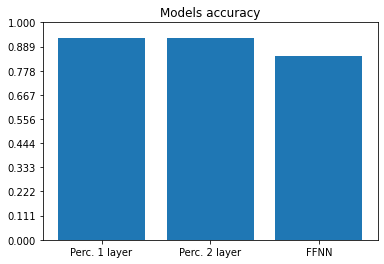

In [228]:
plt.bar(accuracies.keys(), accuracies.values())
plt.title('Models accuracy')
_ = plt.yticks(np.linspace(0, 1, 10))

## Robustness to noise

In [229]:
data_test_with_noise = inject_noise(
    data_test, 
    PreprocParams.noise_level
)

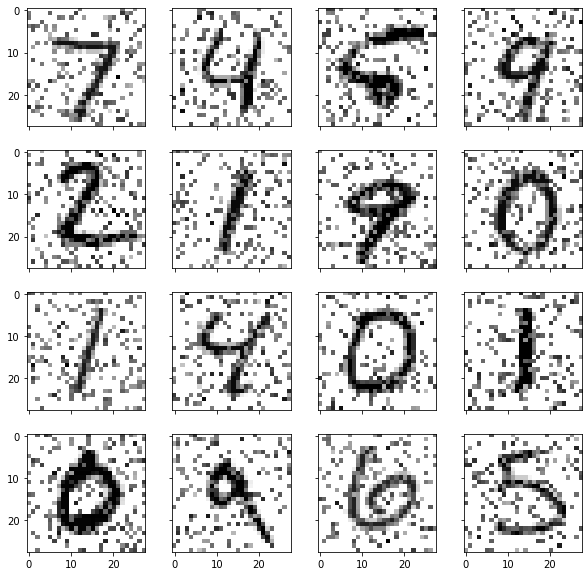

In [230]:
visualize_symbols(
    data_test_with_noise, 
    n_subplots = 16, 
    image_shape = (PreprocParams.crop_size, PreprocParams.crop_size)
)

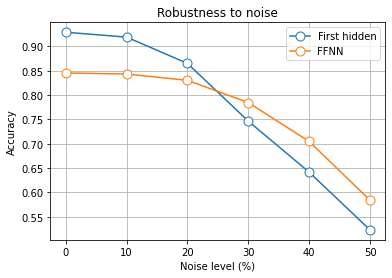

In [234]:
levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5]

plot_noise_robustness_curves(
    levels,
    dbn_model = model_deep, #model_deep,
    ffnn_model = ffnn,
    perceptron_model = perceptrons[0], # perceptron_first_hidden,
    data = data_test,
    targets = targets_test
)

## Adversarial attacks

In [238]:
# Model & test loader preparation
%%capture

dbn_with_readout = DBNWithReadOut(
    dbn_model = model_shallow,
    perceptron = perceptron_first_hidden
)

transformer = tv.transforms.Compose(
        [
            #tv.transforms.CenterCrop(CROP_SIZE_),
            tv.transforms.ToTensor(),
            
            # Transform to {-1, 1} binary image
            tv.transforms.Normalize(
                mean=(PreprocParams.mean,), 
                std=(PreprocParams.std)
            ),

            # Rotate
            # tv.transforms.RandomRotation(degrees = 90) 
        ]
    )

test_loader = torch.utils.data.DataLoader(
    dataset = tv.datasets.EMNIST(
        root = 'data/',
        train = False,
        download = True,
        transform = transformer,
        split = 'digits',
        # shuffle = False
    ),
    batch_size = 1,
    shuffle = True
)
device = torch.device('cpu')

  0%|          | 0/561753746 [00:00<?, ?it/s]

Extracting data/EMNIST/raw/gzip.zip to data/EMNIST/raw


### Example of adversarial attack

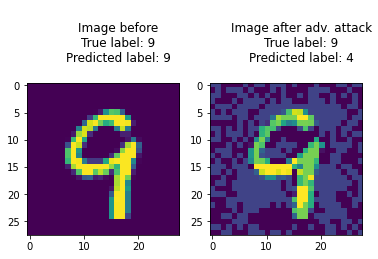

In [239]:
idx = 150
test_label = targets_test[idx]
test_image = data_test[idx].reshape(
    1, 
    PreprocParams.crop_size, 
    PreprocParams.crop_size
)

attack_demo(
    image = test_image,
    label = test_label,
    attacked_model = ffnn
)

### FFNN resistance to adversarial attacks

In [240]:
final_acc = test_robustness_to_attack(
    ffnn, 
    device,
    test_loader,
    epsilon = 0.1,
    num_steps = 0
)

100%|██████████| 40000/40000 [00:34<00:00, 1163.75it/s]


Epsilon: 0.1	Test Accuracy = 6102 / 40000 = 0.15255



### DBN resistance to adversarial attacks

#### 0 Reconstructon steps

In [241]:
final_acc = test_robustness_to_attack(
    dbn_with_readout,
    device,
    test_loader,
    epsilon = PreprocParams.noise_level, 
    num_steps = 0
)

100%|██████████| 40000/40000 [00:40<00:00, 990.69it/s]


Epsilon: 0.2	Test Accuracy = 7076 / 40000 = 0.1769



#### 1 Reconstruction step

  0%|          | 0/40000 [00:00<?, ?it/s]


Here's the original sample:



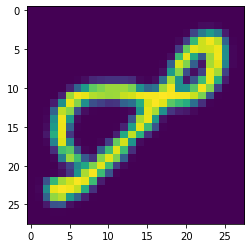


Here's a perturbed sample:



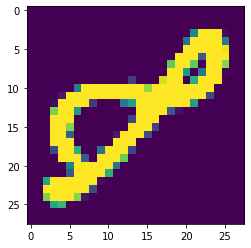


Here's what a 1-steps reconstructed sample looks like:



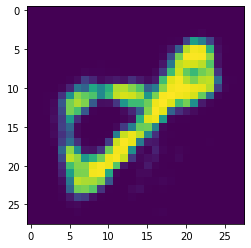

 68%|██████▊   | 27146/40000 [00:31<00:14, 897.79it/s]

In [ ]:
final_acc = test_robustness_to_attack(
    dbn_with_readout, device,
    test_loader,
    epsilon = PreprocParams.noise_level,
    num_steps = 1
)

#### 2 Reconstruction steps

In [ ]:
final_acc = test_robustness_to_attack(
    dbn_with_readout, device,
    test_loader, 
    epsilon = PreprocParams.noise_level,
    num_steps = 2
)

### Effect of noise intensity ($\epsilon$) on FFNN and DBN models

In [ ]:
%%capture
epsilon_values = [0, .05, .1, .15, .2, .25]
reconstruction_steps = [0, 1, 2, 3]

accuracies_ffnn = test_epsilon_values_effect(ffnn, n_steps = 0, epsilons = epsilon_values)

rbm_accuracies = [
    test_epsilon_values_effect(dbn_with_readout, n_steps, epsilon_values) 
    for n_steps in reconstruction_steps
]

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,6), sharey=True)

_ = ax.plot(
    epsilon_values, 
    accuracies_ffnn, 
    marker = 'o',
    markerfacecolor = 'white', 
    markersize = 9
)

for acc in rbm_accuracies:
    _ = ax.plot(
        epsilon_values,
        acc,
        marker = 'o',
        markerfacecolor = 'white', 
        markersize = 9
    )

_ = ax.set_xlabel("$\epsilon$")
_ = ax.set_ylabel("Accuracy")
_ = ax.set_title("Robustness to adversarial attacks")

legends = ['FFNN', *reconstruction_steps]

_ = ax.legend(legends)
plt.grid()